In [1]:
"""This module implements the Fréchet regression method from Petersen and Müller 2019.

The method is implemented in the context of estimation in the space of distribution
functions. Also, a simulation study is designed to compare with the methods outlined in
Petersen and Müller 2016.

"""

'This module implements the Fréchet regression method from Petersen and Müller 2019.\n\nThe method is implemented in the context of estimation in the space of distribution\nfunctions. Also, a simulation study is designed to compare with the methods outlined in\nPetersen and Müller 2016.\n\n'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from frechet_fda.tools.data_generation_tools import (
    gen_params_regression, gen_y_qf, gen_sample_points_from_qfs, make_estimated_pdf
)
from frechet_fda.tools.frechet_tools import solve_frechet_qp, ise_wasserstein
from frechet_fda.tools.function_tools import (
    mean_func, log_qd_transform, inverse_log_qd_transform, get_optimal_range
)

In [3]:
N = 200
seed = 28071995
predictor_bounds = (-1, 1)
mu_params_dict = {
    "mu0" : 0,
    "beta" : 3,
    "v1" : 0.25
}
sigma_params_dict = {
    "sigma0" : 3,
    "gamma" : 0.5,
    "v2" : 2
}

# Define u grid on which to evaluate function points
grid_size = 500
delta = 0 # can start bounded away from zero and one
u = np.linspace(delta, 1 - delta, grid_size)

In [4]:
predictor_vals, mus, sigmas = gen_params_regression(
    mu_params_dict, sigma_params_dict, N, predictor_bounds, seed
)
predictor_vals.shape, mus.shape, sigmas.shape

((200,), (200,), (200,))

In [5]:
# Take only every "slicing_size"th value of predictor grid to calculate estimate
slicing_size = 1
x_grid = predictor_vals[::slicing_size]
x_grid.shape

(200,)

In [6]:
qfs = gen_y_qf(mus, sigmas, u)
qfs = [qf.drop_inf() for qf in qfs]

In [7]:
qfs[0].y.shape

(498,)

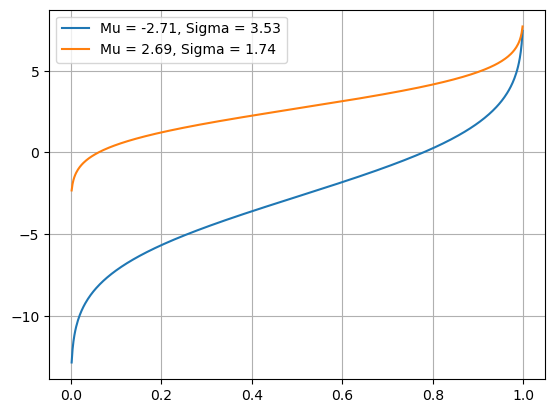

In [8]:
# Select which qfs to compare
first_qf_to_compare = 0
second_qf_to_compare = 199

qfs[first_qf_to_compare].compare(
    qfs[second_qf_to_compare],
    label_self=(
        f"Mu = {round(mus[first_qf_to_compare], 2)}, "
        f"Sigma = {round(sigmas[first_qf_to_compare], 2)}"
    ),
    label_other=(
        f"Mu = {round(mus[second_qf_to_compare], 2)}, "
        f"Sigma = {round(sigmas[second_qf_to_compare], 2)}"
    )
)

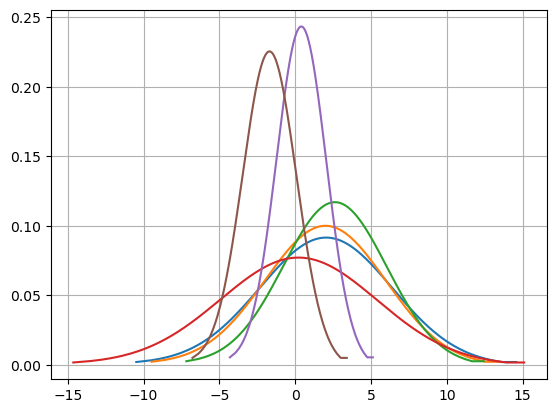

In [9]:
# Plot some densities of the generated distributions
fig, ax = plt.subplots()
some_qfs = np.random.default_rng().choice(qfs, size=6, replace=False)
for qf in some_qfs:
    pdf = qf.invert().differentiate()
    ax.plot(
        pdf.x,
        pdf.y,
    )
plt.grid()
plt.show()

In [10]:
estimates = solve_frechet_qp(
    xs_to_predict = x_grid, x_observed = predictor_vals, quantile_functions = qfs
)

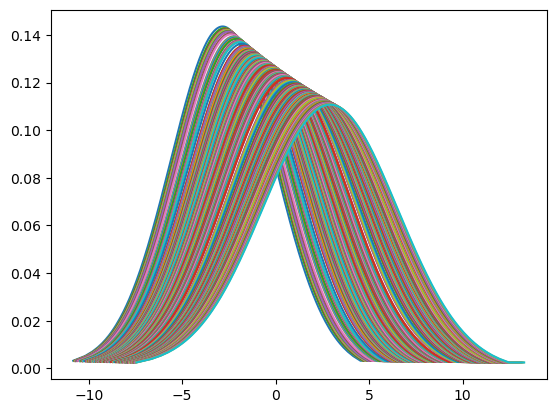

In [11]:
for qf in estimates:
    pdf = qf.invert().differentiate()
    plt.plot(pdf.x, pdf.y)

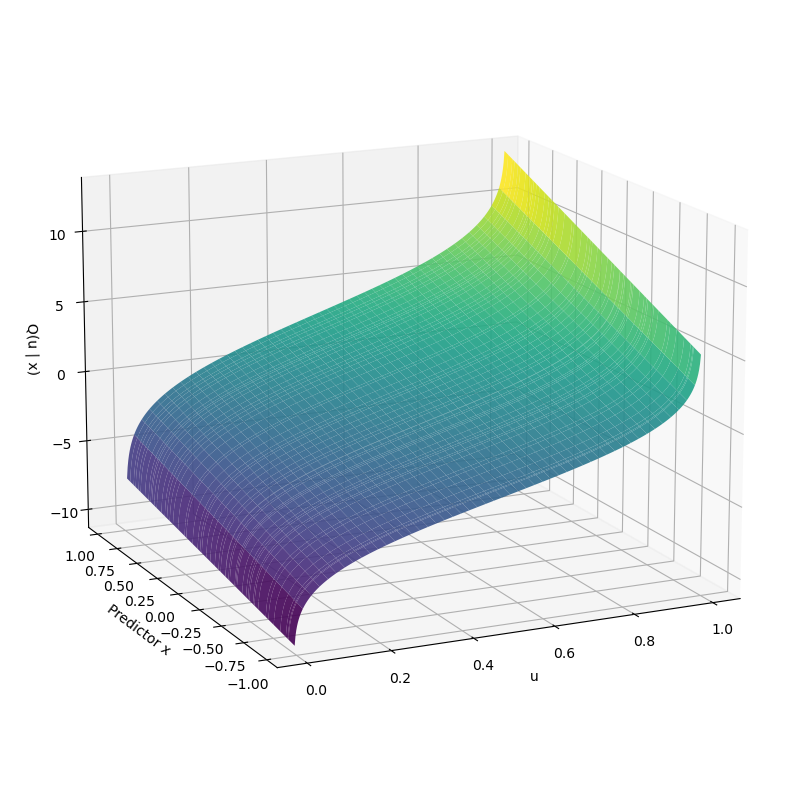

In [12]:
# Initialize a 2D array to hold f(u, x) values
z_values = np.zeros((len(x_grid), len(estimates[0].x)))

# Populate the array with estimates
for i, func in enumerate(estimates):
    z_values[i] = func.y

# Create the 3D surface plot
X, Y = np.meshgrid(estimates[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values, cmap="viridis", alpha=0.9)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=245)

ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)
plt.tight_layout()
plt.show()

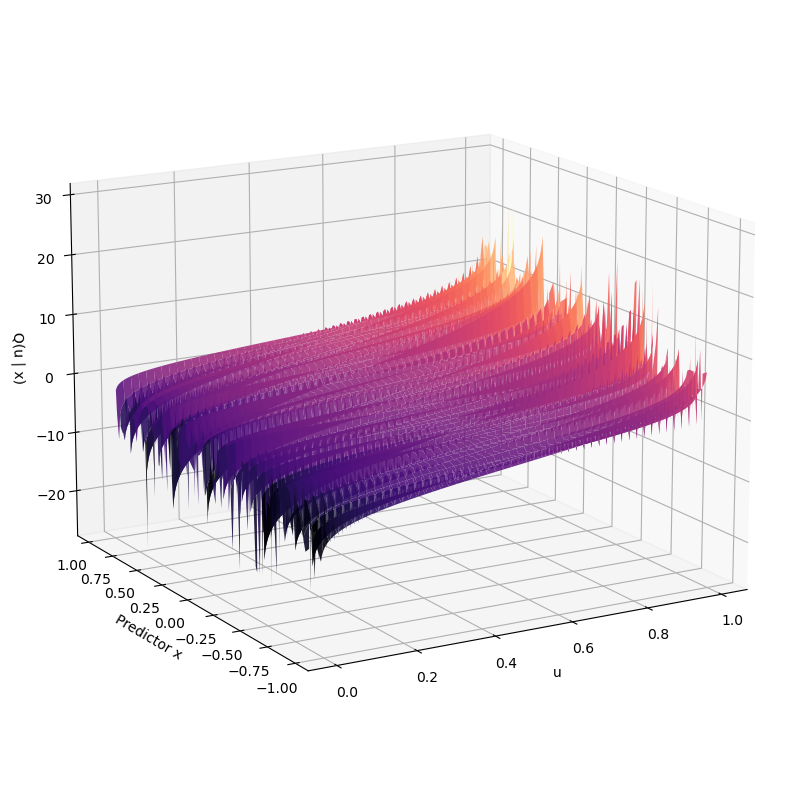

In [13]:
# New z_values for 'qfs'
qfs_of_interest = qfs[::slicing_size]
qfs_of_interest = [qf.drop_inf() for qf in qfs_of_interest]
z_values_qfs_subset = np.zeros((len(x_grid), len(qfs_of_interest[0].x)))
for i, func in enumerate(qfs_of_interest):
    z_values_qfs_subset[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs_subset, cmap="magma", alpha=0.9)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=240)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)

plt.tight_layout()
plt.show()

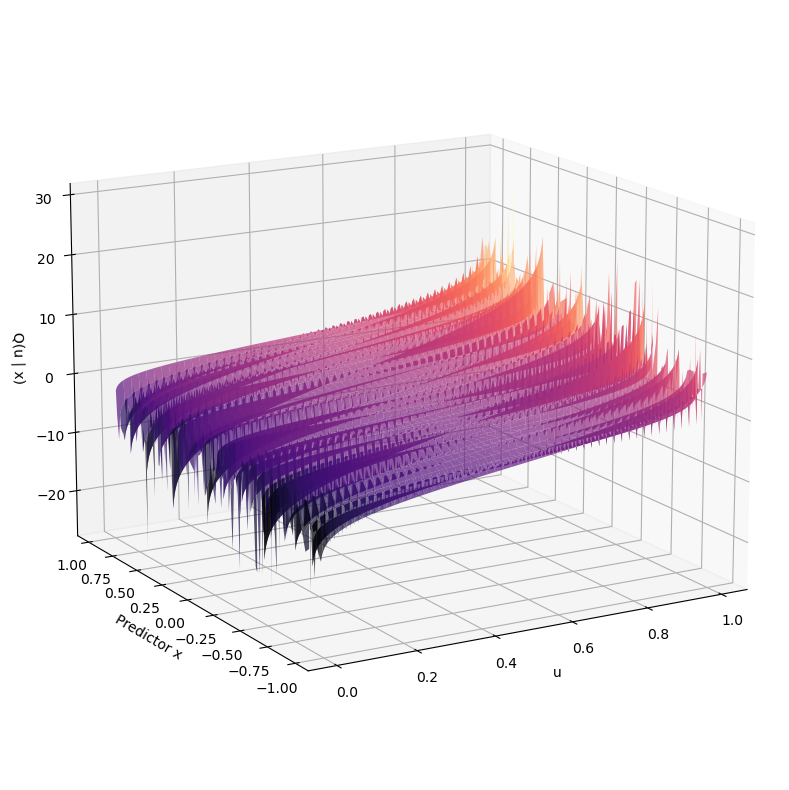

In [14]:
# Plot for all qfs, not just subset
z_values_qfs = np.zeros((len(predictor_vals), len(qfs[0].x)))
for i, func in enumerate(qfs):
    z_values_qfs[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs[0].x, predictor_vals)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=240)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)

plt.tight_layout()
plt.show()

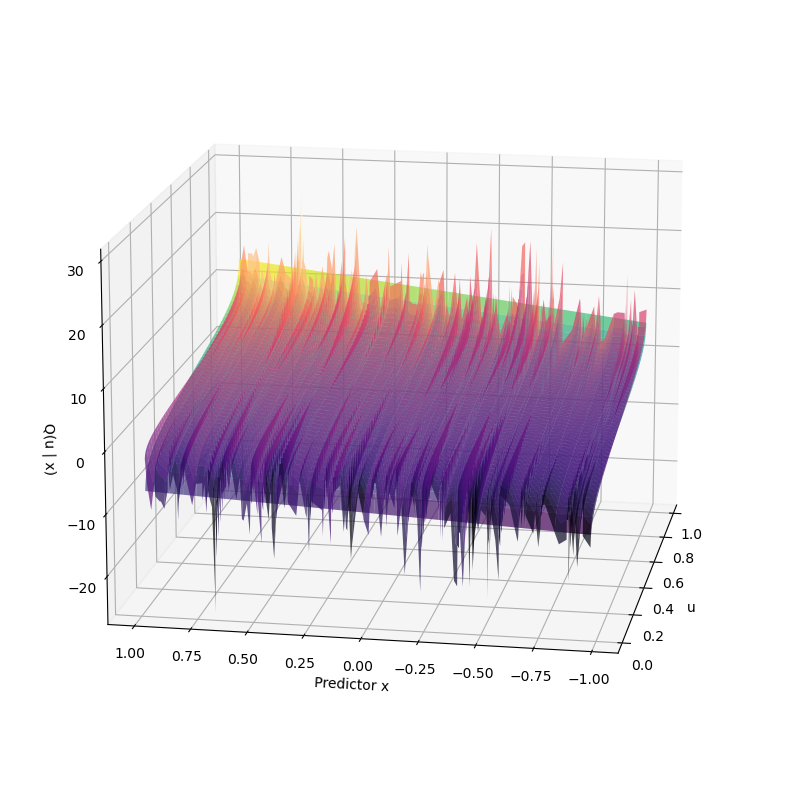

In [15]:
# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(qfs_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values, cmap="viridis", alpha=0.7)

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_qfs_subset, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=190)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)

plt.tight_layout()
plt.show()


### Compute Integrated Squared Error

In [16]:
m_hat = estimates

In [17]:
true_m = qfs[::slicing_size]
true_m = [qf.drop_inf() for qf in true_m]

In [18]:
differences = [hat - true for hat, true in zip(m_hat, true_m, strict=True)]

In [19]:
ise_wasserstein(m_hat, true_m, x_grid, already_qf=True)

3.757029572411895

## Functional Regression with Transformation method

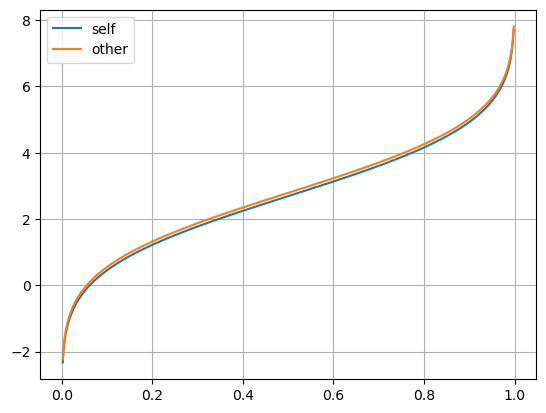

In [20]:
# see whether toying around with function and returning to it changes anything
qfs[199].drop_inf().differentiate().integrate().compare(qfs[199].drop_inf() + 0.1)

In [21]:
pdfs = [qf.drop_inf().invert().differentiate() for qf in qfs]
lqdfs, start_vals = log_qd_transform(pdfs, different_supports=True)

In [22]:
predictor_matrix = np.array((np.ones_like(predictor_vals), predictor_vals)).transpose()
predictor_matrix.shape, np.linalg.inv(
    predictor_matrix.transpose() @ predictor_matrix,
).shape

((200, 2), (2, 2))

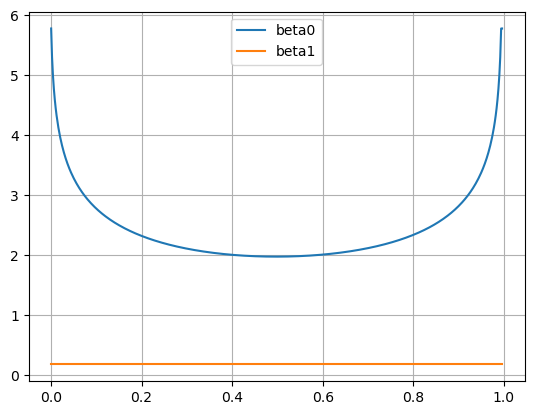

In [23]:
log_betahat = (
    np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix)
    @ predictor_matrix.transpose()
    @ lqdfs
)
log_betahat0 = log_betahat[0]
log_betahat1 = log_betahat[1]
log_betahat0.compare(log_betahat1, label_self="beta0", label_other="beta1")

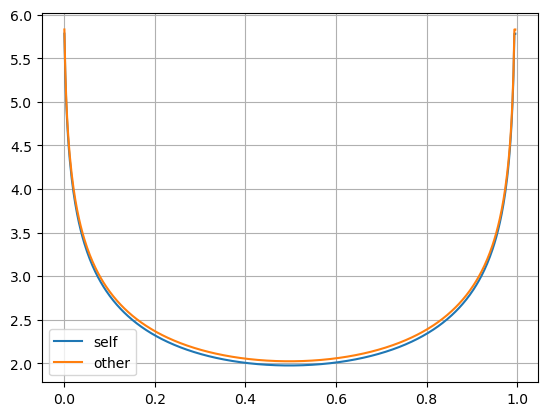

In [24]:
# See that beta0 is equal to the mean of the log qdfs
mean_func(lqdfs).compare(log_betahat0 + 0.05)

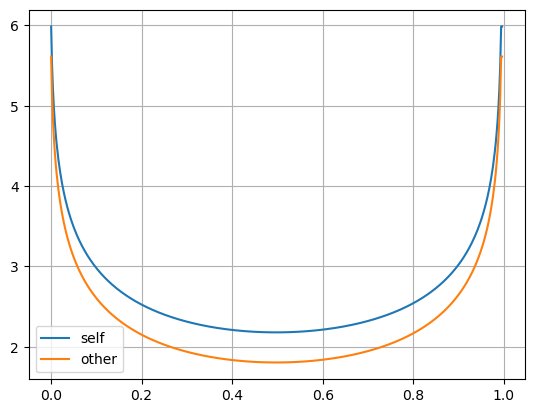

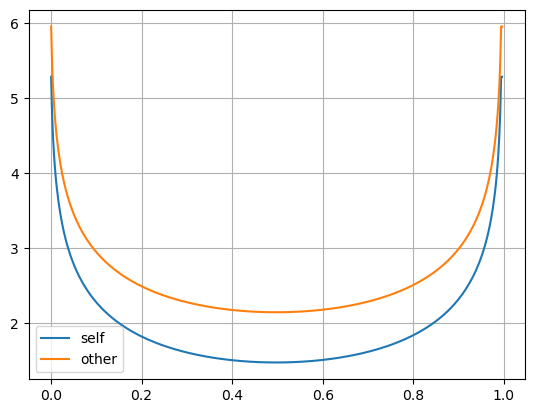

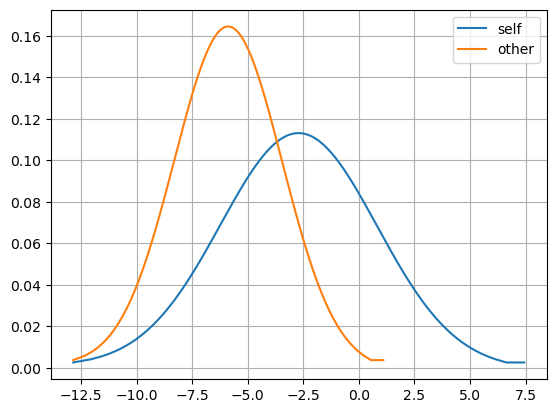

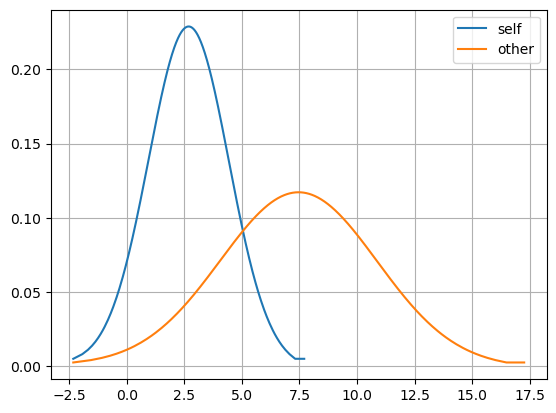

In [25]:
lqdf_hat = predictor_vals * log_betahat1 + log_betahat0
pdf_hat = inverse_log_qd_transform(lqdf_hat, start_vals)
lqdfs[0].compare(lqdf_hat[0])
lqdfs[199].compare(lqdf_hat[199])
pdfs[0].compare(pdf_hat[0])
pdfs[199].compare(pdf_hat[199])

In [26]:
# Calculate integrated squared error
qf_hat = [pdf.integrate().invert() for pdf in pdf_hat]
ise_wasserstein(qf_hat, qfs, predictor_vals, already_qf=True)

37.10838775268246

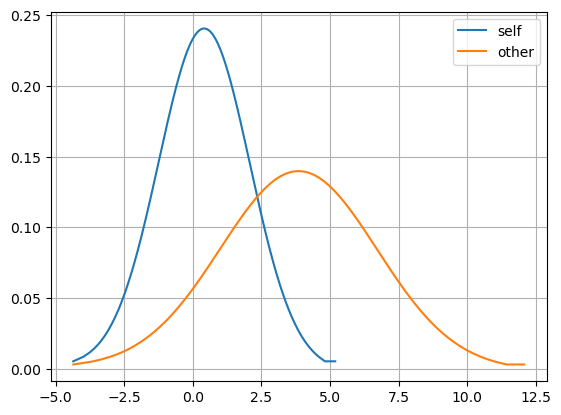

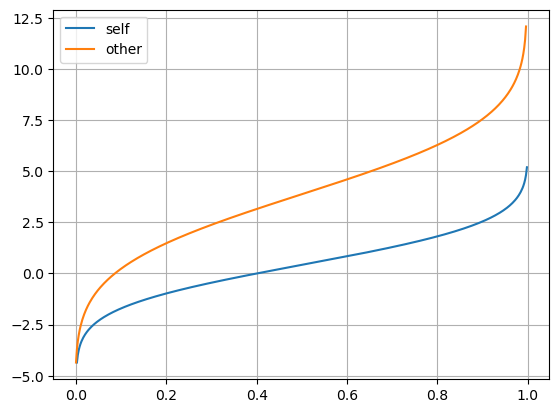

In [27]:
distribution_of_interest = 100
pdfs[distribution_of_interest].compare(pdf_hat[distribution_of_interest])
qfs[distribution_of_interest].compare(
    pdf_hat[distribution_of_interest].integrate().invert(),
)

## For demonstration of estimation effects

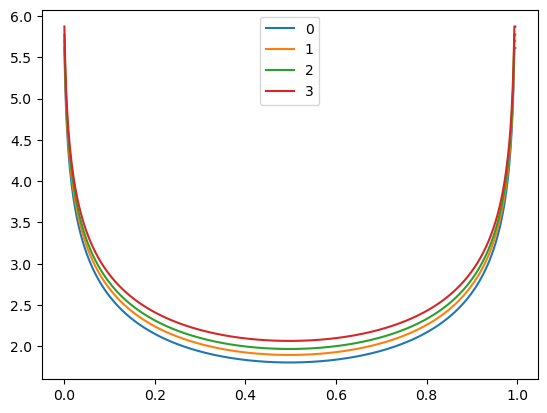

In [28]:
for i, lqd in enumerate(lqdf_hat[::50]):
    plt.plot(lqd.x, lqd.y, label=i)
plt.legend()
plt.show()

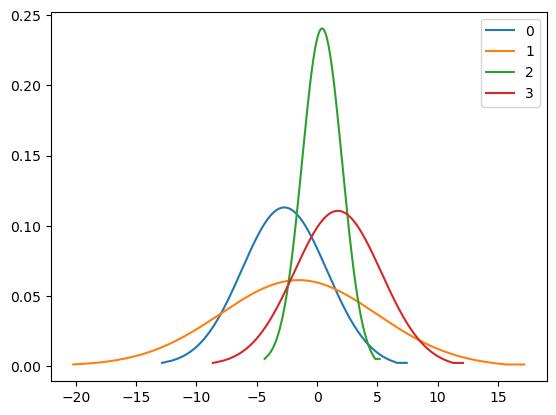

In [29]:
for i, pdf in enumerate(pdfs[::50]):
    plt.plot(pdf.x, pdf.y, label=i)
plt.legend()
plt.show()

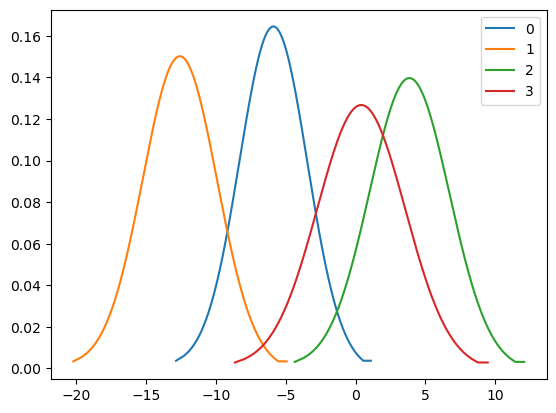

In [30]:
for i, pdf in enumerate(pdf_hat[::50]):
    plt.plot(pdf.x, pdf.y, label=i)
plt.legend()
plt.show()

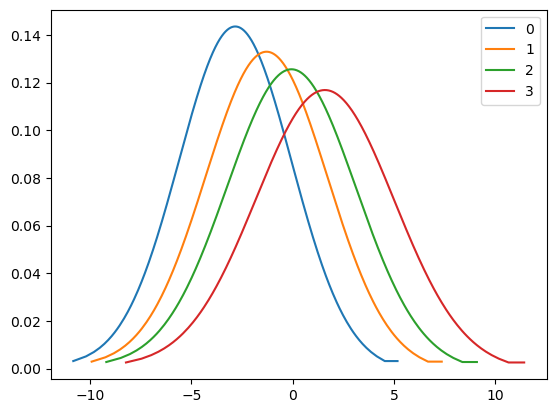

In [31]:
for i, qf in enumerate(estimates[::50]):
    pdf = qf.invert().differentiate()
    plt.plot(pdf.x, pdf.y, label=i)
plt.legend()
plt.show()

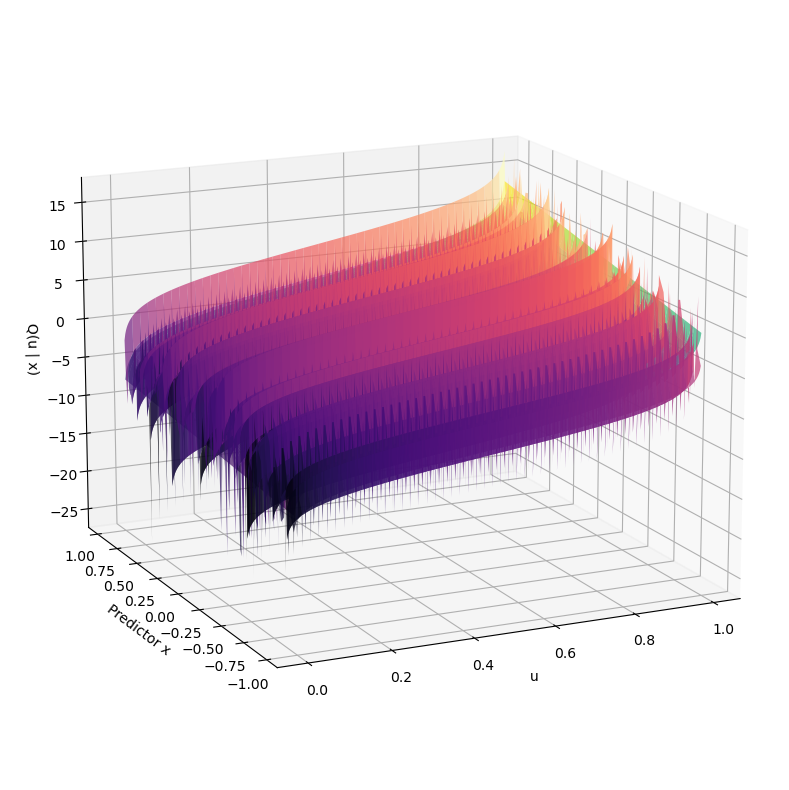

In [32]:
# New z_values for 'qfs'
hats_of_interest = [
    pdf.integrate().invert().drop_inf() for pdf in pdf_hat[::slicing_size]
]
z_values_pdf_hats = np.zeros((len(x_grid), len(hats_of_interest[0].x)))
for i, func in enumerate(hats_of_interest):
    z_values_pdf_hats[i] = func.y

# Create the 3D surface plot for 'estimates'
X, Y = np.meshgrid(hats_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values, cmap="viridis", alpha=0.7)

# Create the 3D surface plot for 'qfs'
ax.plot_surface(X, Y, z_values_pdf_hats, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=245)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)

plt.tight_layout()
plt.show()

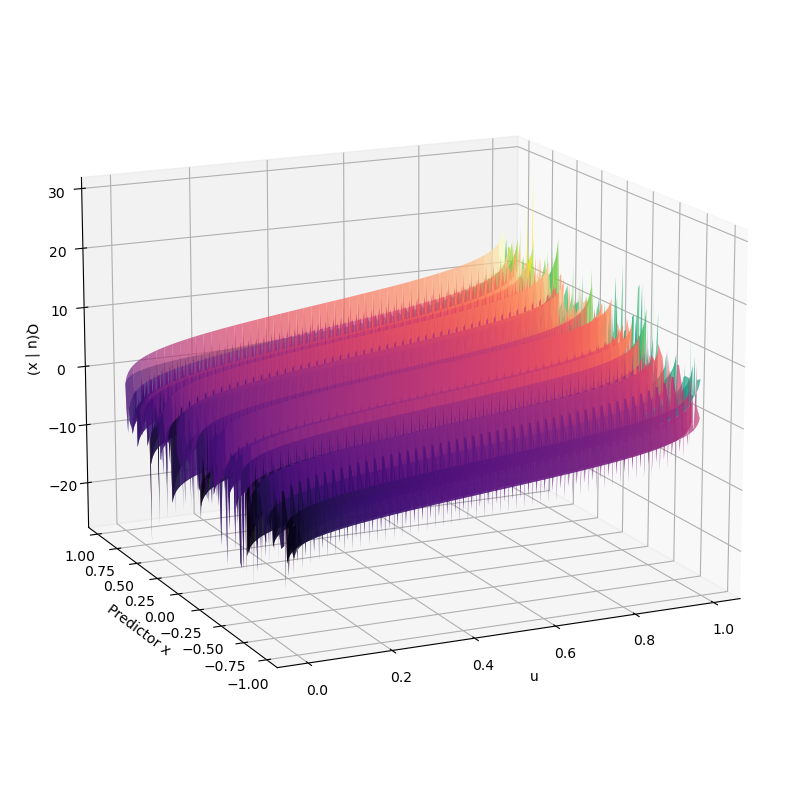

In [33]:
# Create the 3D surface plot for qfs
X, Y = np.meshgrid(hats_of_interest[0].x, x_grid)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, z_values_qfs_subset, cmap="viridis", alpha=0.7)

# Create the 3D surface plot for functional regression estimates
ax.plot_surface(X, Y, z_values_pdf_hats, cmap="magma", alpha=0.7)

# Adjust the viewing angle for better visibility
ax.view_init(elev=15, azim=245)

# Add labels
ax.set_xlabel("u")
ax.set_ylabel("Predictor x")
ax.set_zlabel("Q(u | x)", rotation=0)

plt.tight_layout()
plt.show()

# Simulation

In [34]:
# Number of simulations
m = 500
# Number of samples of densities to generate
sample_sizes = [50, 100, 200]
# Number of sample points to generate from each density for density estimation step
points_number = 100
# Which kernel to use in density estimation
which_kernel = "std_normal"
# Set interval within which to estimate densities, approx of -inf and inf
denstimation_limits = (-30,30)
# Fineness of grids to evaluate functions
grid_size = 500
delta = 0 # can start bounded away from zero and one
u = np.linspace(delta, 1 - delta, grid_size)
# Parameters for stochastic process that generates conditional distributions
predictor_bounds = (-1, 1)
mu_params_dict = {"mu0" : 0, "beta" : 3, "v1" : 0.25}
sigma_params_dict = {"sigma0" : 3, "gamma" : 0.5, "v2" : 2}
# Take only every "slicing_size"th value of predictor grid to calculate estimate (see
# comment in simulation)
slicing_size = 1

# For storing simulation results
stored_ise_frechet = np.empty((m, len(sample_sizes)))
stored_ise_func_reg = np.empty((m, len(sample_sizes)))
stored_ise_frechet_denstimation = np.empty((m, len(sample_sizes)))
stored_ise_func_reg_denstimation = np.empty((m, len(sample_sizes)))

In [35]:
total_iterations = m * len(sample_sizes)  # Total iterations
progress_bar = tqdm(total=total_iterations, desc="Simulation")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing ISE values below!
        # Set parameters
        seed_num = int(str(i) + str(j))  # unique seed in each simulation run
        predictor_vals, mus, sigmas = gen_params_regression(
            mu_params_dict, sigma_params_dict, n, predictor_bounds, seed_num
        )

        # Choose for which x_vals to predict conditional quantiles (predicting at
        # every x from predictor_vals would be very computationally expensive)
        x_grid = predictor_vals[::slicing_size]

        # Generate conditional distributions
        qfs = gen_y_qf(mus, sigmas, u)
        qfs = [qf.drop_inf() for qf in qfs]
        pdfs = [qf.invert().differentiate() for qf in qfs]

        # Estimate conditional quantile function given x
        m_hat = solve_frechet_qp(
            xs_to_predict = x_grid,
            x_observed = predictor_vals,
            quantile_functions = qfs
        )

        # Take subset of qfs that corresponds to the estimated m_hats
        true_m = qfs[::slicing_size]

        # Store estimation error
        stored_ise_frechet[i, j] = ise_wasserstein(
            m_hat, true_m, x_grid, already_qf=True
        )


        ## Transformation method
        lqdfs, start_vals = log_qd_transform(pdfs, different_supports=True)

        # Calculate effect of x on lqdf
        predictor_matrix = np.array(
            (np.ones_like(predictor_vals), predictor_vals)
        ).transpose()
        log_betahat = (
            np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix)
            @ predictor_matrix.transpose()
            @ lqdfs
        )

        # Estimated lqdfs and their inverse transforms
        lqdf_hat = predictor_vals * log_betahat[1] + log_betahat[0]
        pdf_hat = inverse_log_qd_transform(lqdf_hat, start_vals)
        qf_hat = [pdf.integrate().invert() for pdf in pdf_hat[::slicing_size]]

        # Store estimation error
        stored_ise_func_reg[i, j] = ise_wasserstein(
            qf_hat, true_m, x_grid, already_qf=True
        )




        ### With density estimation
        sample_points = gen_sample_points_from_qfs(qfs, points_number, seed_num)

        # Density estimation
        # Rule-of-Thumb bandwidth (Li and Racine 2007, p. 66)
        bandwidth = np.std(sample_points, axis=0) * (n ** (-0.2))
        temp_estimated_pdfs = make_estimated_pdf(
            sample_points=sample_points,
            a=denstimation_limits[0] * np.ones(n),
            b=denstimation_limits[1] * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth,
            bias_corrected=False
        )
        # Get actual support
        new_ranges = get_optimal_range(temp_estimated_pdfs)
        # Generate numerically stable objects, within individual ranges
        estimated_pdfs = make_estimated_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=bandwidth,
            bias_corrected=False
        )
        estimated_qfs = [pdf.integrate().invert() for pdf in estimated_pdfs]

        # Estimate conditional quantile function given x
        m_hat = solve_frechet_qp(
            xs_to_predict = x_grid,
            x_observed = predictor_vals,
            quantile_functions = estimated_qfs
        )

        # Take subset of qfs that corresponds to the estimated m_hats
        true_m = qfs[::slicing_size]

        # Store estimation error
        stored_ise_frechet_denstimation[i, j] = ise_wasserstein(
            m_hat, true_m, x_grid, already_qf=True
        )


        ## Transformation method
        estimated_lqdfs, start_vals = log_qd_transform(
            estimated_pdfs, different_supports=True
        )

        # Calculate effect of x on lqdf
        predictor_matrix = np.array(
            (np.ones_like(predictor_vals), predictor_vals)
        ).transpose()
        log_betahat = (
            np.linalg.inv(predictor_matrix.transpose() @ predictor_matrix)
            @ predictor_matrix.transpose()
            @ estimated_lqdfs
        )

        # Estimated lqdfs and their inverse transforms
        lqdf_hat = predictor_vals * log_betahat[1] + log_betahat[0]
        pdf_hat = inverse_log_qd_transform(lqdf_hat, start_vals)
        qf_hat = [pdf.integrate().invert() for pdf in pdf_hat[::slicing_size]]

        # Store estimation error
        stored_ise_func_reg_denstimation[i, j] = ise_wasserstein(
            qf_hat, true_m, x_grid, already_qf=True
        )

        # Print progress of simulation
        progress_bar.update()
progress_bar.close()

Simulation:   0%|          | 0/1500 [00:00<?, ?it/s]

Simulation:   1%|          | 16/1500 [00:55<1:23:44,  3.39s/it]

KeyboardInterrupt: 

In [ ]:
(
    np.mean(stored_ise_frechet, axis=0),
    np.mean(stored_ise_func_reg, axis=0),
    np.mean(stored_ise_frechet_denstimation, axis=0),
    np.mean(stored_ise_func_reg_denstimation, axis=0),
)

(array([2.84486518, 2.9829651 , 4.03716692]),
 array([28.95464539, 28.20236783, 38.94888624]),
 array([12.26066989, 12.68639215, 21.93963434]),
 array([28.55750509, 29.4389015 , 52.09555438]))

Without density estimation step, unclear effect of increasing sample size; error decreases
from 50 to 100 for both methods, but increases from 100 to 200. Maybe here numerical
inacurracies dominate, while error when density estimation is included is mainly driven
from having to estimate densities. They profit from having more densities observed?